In [80]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [81]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [82]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [83]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [84]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [85]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [86]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [87]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [88]:
# Find the most recent date in the data set.
most_recent = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(most_recent)

('2017-08-23',)


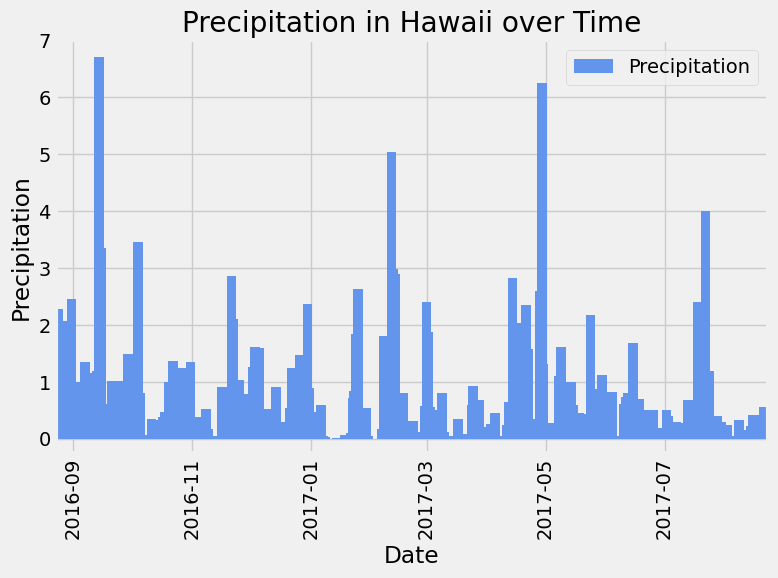

In [89]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = pd.to_datetime(most_recent[0]).date()

# Calculate the date one year from the last date in data set.
year_ago =  most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date <= most_recent_date).\
    filter(measurement.date >= year_ago).\
    order_by(measurement.date)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation, columns = ["Date", "Precipitation"])

# Sort the dataframe by date
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])
sorted_df = precipitation_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize = (8, 6))
plt.bar(sorted_df['Date'], sorted_df['Precipitation'], label = "Precipitation", color = 'cornflowerblue', width = 5)
sorted_df.set_index('Date')

# Formatting
plt.xticks(rotation = 90)
plt.title("Precipitation in Hawaii over Time")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.xlim(year_ago, most_recent_date)
plt.ylim(-0.25, 7)
plt.legend()
plt.tight_layout()

# Display chart
plt.show()

In [90]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary = sorted_df["Precipitation"].describe()
summary

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [91]:
# Design a query to calculate the total number of stations in the dataset
station_no = session.query(func.count(func.distinct(measurement.station))).all()
station_no

[(9,)]

In [92]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [93]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Find most active station
printed_stations = [station for station, count in active_stations]
most_active_station = printed_stations[0]

# Take min, max, avg of tobs
sel = [func.min(measurement.tobs), 
       func.max(measurement.tobs),
       func.avg(measurement.tobs)]

# Query for tobs data for most active station
most_active = session.query(*sel).\
    filter(measurement.station == most_active_station).\
    group_by(measurement.station).all()

most_active
    

[(54.0, 85.0, 71.66378066378067)]

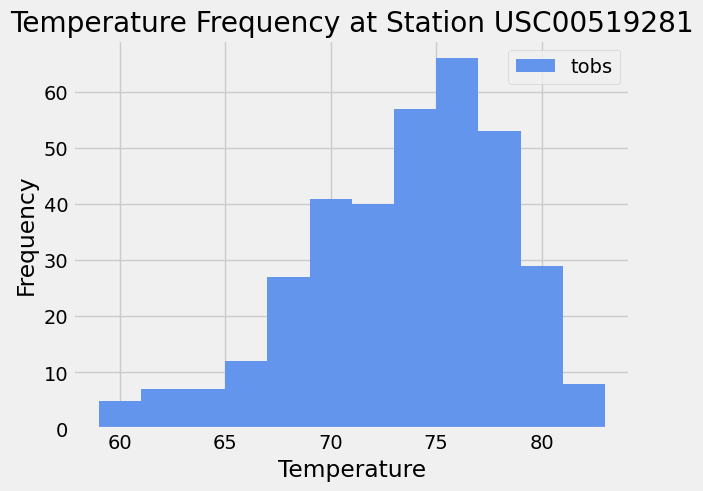

In [94]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_temps = session.query(measurement.tobs).\
    filter(measurement.station == most_active_station).\
    filter(measurement.date <= most_recent_date).\
    filter(measurement.date >= year_ago).all()

# Extract only the temperature values
temp_values = [temp[0] for temp in most_active_temps]

# plot the histogram
plt.hist(temp_values, bins = 12, label = 'tobs', color = 'cornflowerblue')

# formatting
plt.title(f'Temperature Frequency at Station {most_active_station}')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()

# display graph
plt.show()


# Close Session

In [95]:
# Close Session
session.close()